### the goal of this notebook is to compare orthophotos of varying resolutions and compressions

In [21]:
import rasterio
from rasterio.windows import Window
import os
import matplotlib.pyplot as plt
import rasterio.plot
import numpy as np



C:\Users\nilsdi\AppData\Local\Temp\ipykernel_2588\1653258213.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


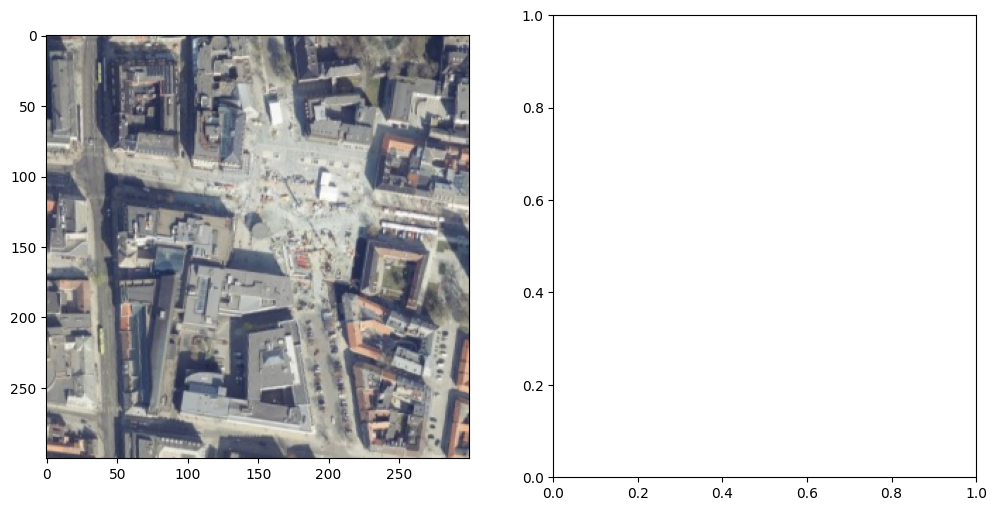

In [32]:
compared_settings = [
    {'res':1, 'project':'trondheim 2019', 'compression_value':50},
    #{'res':1, 'project':'trondheim 2019', 'compression_value':50},
    ]
project_paths = []
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
for data in compared_settings:
    file_name = f"i_lzw_{data['compression_value']}/Eksport-nib.tif"
    extract_path = parent_dir + f"/data/raw/orthophoto/res_{data['res']}/{data['project']}/"
    project_paths.append(extract_path + file_name)

# Define a shared window
col_off = 19500  # column offset (in m)
row_off = 3900  # row offset (in m)
width = 300  # width of the window (in m)
height = 300  # height of the window (in m)


# set up a multifigure plot to compare the orthophotos
# make sure we have enough rows for all projects (2 columns and as many rows as needed)
n_rows = round(len(project_paths)/2 + 0.25)
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 6))

# Flatten the axs array to easily iterate over it
axs = axs.flatten()

for ax, geotiff_path, settings in zip(axs, project_paths, compared_settings):
    # Create a window that is adjusted for pixels (not meters)
    pixel_size = settings['res']
    window = Window(col_off/pixel_size, row_off/pixel_size, width/pixel_size, height/pixel_size)
    # Read the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        # Read a subset of the GeoTIFF data
        subset = src.read([1,2,3], window=window)
        # Display the data in the current subplot
        #rasterio.plot.show(subset, ax=ax, transform=src.transform)
        # Rearrange the dimensions of the array
        subset = np.transpose(subset, (1, 2, 0))
        # Display the data in the current subplot
        ax.imshow(subset)
fig.show()
